In [1]:
import sys
sys.path.append('..')

from src.rag_chain import create_rag_chain, ask_question
from src.config import GROQ_MODEL, TEMPERATURE, RETRIEVAL_K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import json

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Setup complete!")

✅ Setup complete!


In [ ]:
print("Loading RAG chain...")
chain = create_rag_chain(verbose=False)
print(f"✅ Chain loaded")
print(f"   Model: {GROQ_MODEL}")
print(f"   Temperature: {TEMPERATURE}")
print(f"   Retrieval K: {RETRIEVAL_K}")

In [3]:
test_cases = [
    {
        "question": "What's the optimal daily protein intake for muscle growth?",
        "category": "nutrition",
        "expected_keywords": ["protein", "gram", "kg", "body weight", "muscle"],
        "difficulty": "easy"
    },
    {
        "question": "How should I structure my training split for hypertrophy?",
        "category": "training",
        "expected_keywords": ["split", "frequency", "volume", "muscle group"],
        "difficulty": "medium"
    },
    {
        "question": "What are the best exercises for chest development?",
        "category": "training",
        "expected_keywords": ["chest", "press", "bench", "exercise"],
        "difficulty": "easy"
    },
    {
        "question": "Should I do cardio while bulking and how much?",
        "category": "nutrition",
        "expected_keywords": ["cardio", "bulk", "calorie", "surplus"],
        "difficulty": "medium"
    },
    {
        "question": "How to prevent common training injuries?",
        "category": "training",
        "expected_keywords": ["injury", "warm", "technique", "prevent"],
        "difficulty": "medium"
    },
    {
        "question": "Which supplements are actually worth taking?",
        "category": "nutrition",
        "expected_keywords": ["supplement", "creatine", "protein", "effective"],
        "difficulty": "easy"
    },
    {
        "question": "Explain the science of muscle protein synthesis",
        "category": "science",
        "expected_keywords": ["protein synthesis", "mtor", "amino acid", "muscle"],
        "difficulty": "hard"
    },
    {
        "question": "How does sleep affect muscle recovery and growth?",
        "category": "lifestyle",
        "expected_keywords": ["sleep", "recovery", "growth", "hormone"],
        "difficulty": "medium"
    },
    {
        "question": "What's the difference between powerlifting and bodybuilding training?",
        "category": "training",
        "expected_keywords": ["powerlifting", "bodybuilding", "strength", "hypertrophy"],
        "difficulty": "medium"
    },
    {
        "question": "How do I calculate my maintenance calories?",
        "category": "nutrition",
        "expected_keywords": ["calorie", "maintenance", "tdee", "calculate"],
        "difficulty": "easy"
    },
]

print(f"\nTest Cases: {len(test_cases)}")


Test Cases: 10


In [4]:
def evaluate_answer_quality(answer, expected_keywords):
    """Check if answer contains expected keywords"""
    answer_lower = answer.lower()
    keyword_hits = sum(1 for kw in expected_keywords if kw.lower() in answer_lower)
    return keyword_hits / len(expected_keywords)

def check_hallucination_indicators(answer):
    """Check for phrases that might indicate hallucination"""
    hallucination_phrases = [
        "according to the course",
        "the course states",
        "on page",
        "module",
        "as mentioned in"
    ]
    return sum(1 for phrase in hallucination_phrases if phrase in answer.lower())

def assess_answer_length(answer):
    """Assess if answer is appropriate length"""
    word_count = len(answer.split())
    if word_count < 50:
        return "too_short"
    elif word_count > 300:
        return "too_long"
    else:
        return "appropriate"

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


In [7]:
print("\nRunning RAG evaluation (this will take a few minutes)...")

results = []

for test in tqdm(test_cases, desc="Evaluating RAG"):
    question = test["question"]
    
    # Measure performance
    start_time = time.time()
    try:
        answer, sources = ask_question(chain, question, verbose=False)
        latency = time.time() - start_time
        success = True
        error = None
    except Exception as e:
        answer = ""
        sources = []
        latency = time.time() - start_time
        success = False
        error = str(e)
    
    # Evaluate answer quality
    keyword_score = evaluate_answer_quality(answer, test["expected_keywords"]) if success else 0
    hallucination_count = check_hallucination_indicators(answer) if success else 0
    length_assessment = assess_answer_length(answer) if success else "error"
    word_count = len(answer.split()) if success else 0
    
    # Source quality
    num_sources = len(sources)
    correct_category = sum(1 for doc in sources if doc.metadata.get('category') == test['category'])
    category_precision = correct_category / num_sources if num_sources > 0 else 0
    
    results.append({
        "question": question,
        "category": test["category"],
        "difficulty": test["difficulty"],
        "success": success,
        "latency_s": latency,
        "word_count": word_count,
        "keyword_score": keyword_score,
        "hallucination_count": hallucination_count,
        "length_assessment": length_assessment,
        "num_sources": num_sources,
        "category_precision": category_precision,
        "answer": answer[:200] + "..." if len(answer) > 200 else answer,
        "error": error
    })
    
    # Small delay to avoid rate limiting
    time.sleep(0.5)

df_results = pd.DataFrame(results)

print("\n✅ Evaluation complete!")


Running RAG evaluation (this will take a few minutes)...


Evaluating RAG:   0%|          | 0/10 [00:00<?, ?it/s]2026-02-15 11:07:04,681 - src.rag_chain - INFO - Question: What's the optimal daily protein intake for muscle growth?
2026-02-15 11:07:05,274 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating RAG:  10%|█         | 1/10 [00:01<00:09,  1.10s/it]2026-02-15 11:07:05,778 - src.rag_chain - INFO - Question: How should I structure my training split for hypertrophy?
2026-02-15 11:07:07,084 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating RAG:  20%|██        | 2/10 [00:02<00:12,  1.52s/it]2026-02-15 11:07:07,588 - src.rag_chain - INFO - Question: What are the best exercises for chest development?
2026-02-15 11:07:08,416 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
Evaluating RAG:  30%|███       | 3/10 [00:04<00:10,  1.43s/it]2026-02-15 11:07:08,920 - src.rag_cha


✅ Evaluation complete!


In [8]:
print("\n" + "="*80)
print("RAG PERFORMANCE METRICS")
print("="*80)

# Success rate
success_rate = df_results['success'].sum() / len(df_results)
print(f"\n✅ Success Rate: {success_rate:.1%}")

# Latency statistics
successful_runs = df_results[df_results['success'] == True]
if len(successful_runs) > 0:
    print(f"\n⏱️  Latency Statistics:")
    print(f"   Mean: {successful_runs['latency_s'].mean():.2f}s")
    print(f"   Median: {successful_runs['latency_s'].median():.2f}s")
    print(f"   Min: {successful_runs['latency_s'].min():.2f}s")
    print(f"   Max: {successful_runs['latency_s'].max():.2f}s")
    print(f"   Std Dev: {successful_runs['latency_s'].std():.2f}s")
    
    # Quality metrics
    print(f"\n📈 Quality Metrics:")
    print(f"   Mean Keyword Score: {successful_runs['keyword_score'].mean():.2%}")
    print(f"   Mean Category Precision: {successful_runs['category_precision'].mean():.2%}")
    print(f"   Avg Word Count: {successful_runs['word_count'].mean():.0f} words")
    print(f"   Hallucination Indicators: {successful_runs['hallucination_count'].sum():.0f} total")
    
    # Length assessment
    print(f"\nAnswer Length Assessment:")
    length_counts = successful_runs['length_assessment'].value_counts()
    for length_type, count in length_counts.items():
        print(f"   {length_type}: {count} ({count/len(successful_runs)*100:.1f}%)")
else:
    print("\nFailed questions:")
    for idx, row in df_results[df_results['success'] == False].iterrows():
        print(f"   - {row['question']}")
        print(f"     Error: {row['error']}")

print("\n" + "="*80)


RAG PERFORMANCE METRICS

✅ Success Rate: 100.0%

⏱️  Latency Statistics:
   Mean: 3.92s
   Median: 3.95s
   Min: 0.60s
   Max: 8.12s
   Std Dev: 3.02s

📈 Quality Metrics:
   Mean Keyword Score: 78.50%
   Mean Category Precision: 86.67%
   Avg Word Count: 215 words
   Hallucination Indicators: 0 total

Answer Length Assessment:
   appropriate: 9 (90.0%)
   too_long: 1 (10.0%)



In [9]:
category_perf = successful_runs.groupby('category').agg({
    'latency_s': 'mean',
    'keyword_score': 'mean',
    'category_precision': 'mean',
    'word_count': 'mean'
}).round(3)

print("\n📊 PERFORMANCE BY CATEGORY:")
print(category_perf)


📊 PERFORMANCE BY CATEGORY:
           latency_s  keyword_score  category_precision  word_count
category                                                           
lifestyle      7.219          1.000               1.000       275.0
nutrition      3.352          0.588               1.000       167.5
science        6.229          1.000               0.000       260.0
training       3.074          0.875               0.917       236.0


In [10]:
difficulty_perf = successful_runs.groupby('difficulty').agg({
    'latency_s': 'mean',
    'keyword_score': 'mean',
    'category_precision': 'mean',
    'word_count': 'mean'
}).round(3)

print("\n📊 PERFORMANCE BY DIFFICULTY:")
print(difficulty_perf)


📊 PERFORMANCE BY DIFFICULTY:
            latency_s  keyword_score  category_precision  word_count
difficulty                                                          
easy            3.327          0.712               1.000       174.0
hard            6.229          1.000               0.000       260.0
medium          3.923          0.800               0.933       238.6


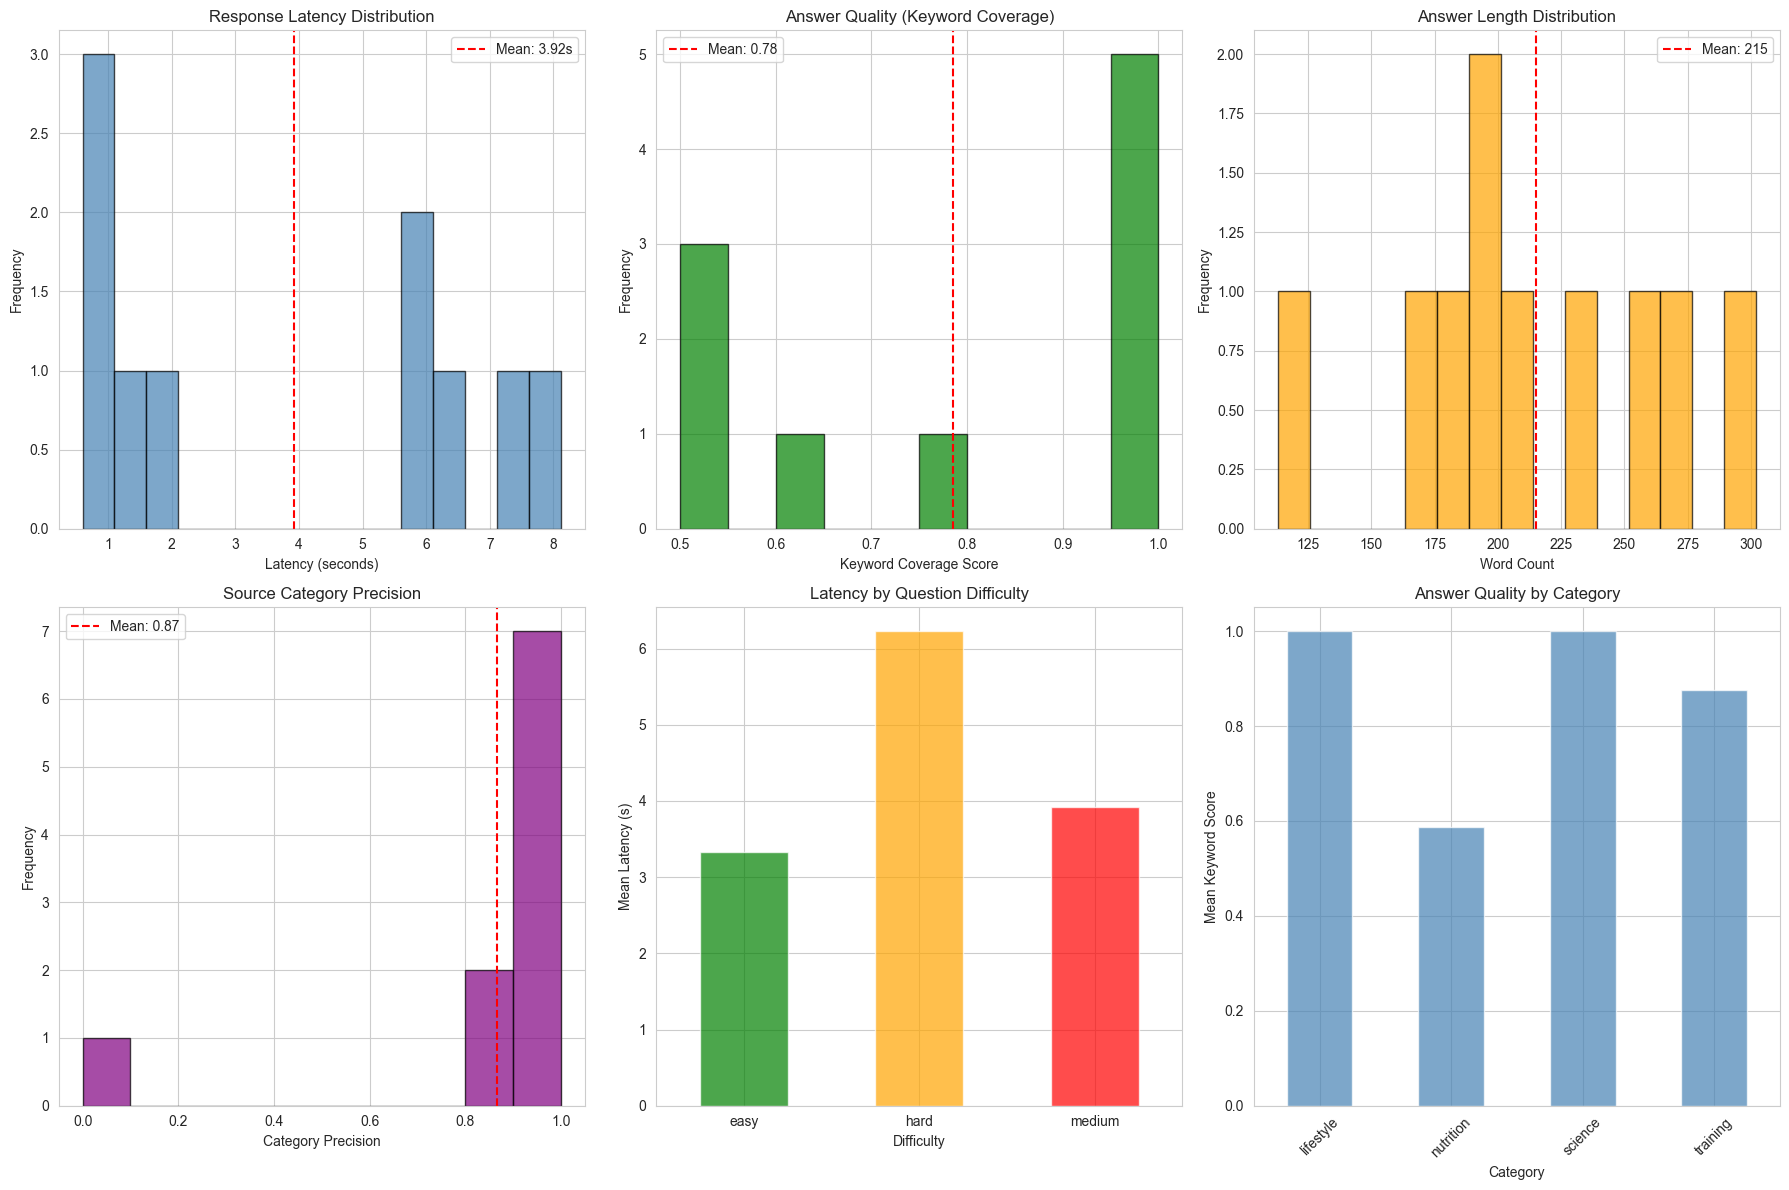

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Latency distribution
axes[0, 0].hist(successful_runs['latency_s'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(successful_runs['latency_s'].mean(), color='red', linestyle='--', label=f'Mean: {successful_runs["latency_s"].mean():.2f}s')
axes[0, 0].set_xlabel('Latency (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Response Latency Distribution')
axes[0, 0].legend()

# 2. Keyword score distribution
axes[0, 1].hist(successful_runs['keyword_score'], bins=10, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(successful_runs['keyword_score'].mean(), color='red', linestyle='--', label=f'Mean: {successful_runs["keyword_score"].mean():.2f}')
axes[0, 1].set_xlabel('Keyword Coverage Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Answer Quality (Keyword Coverage)')
axes[0, 1].legend()

# 3. Word count distribution
axes[0, 2].hist(successful_runs['word_count'], bins=15, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].axvline(successful_runs['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {successful_runs["word_count"].mean():.0f}')
axes[0, 2].set_xlabel('Word Count')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Answer Length Distribution')
axes[0, 2].legend()

# 4. Category precision
axes[1, 0].hist(successful_runs['category_precision'], bins=10, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(successful_runs['category_precision'].mean(), color='red', linestyle='--', label=f'Mean: {successful_runs["category_precision"].mean():.2f}')
axes[1, 0].set_xlabel('Category Precision')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Source Category Precision')
axes[1, 0].legend()

# 5. Latency by difficulty
difficulty_perf['latency_s'].plot(kind='bar', ax=axes[1, 1], color=['green', 'orange', 'red'], alpha=0.7)
axes[1, 1].set_xlabel('Difficulty')
axes[1, 1].set_ylabel('Mean Latency (s)')
axes[1, 1].set_title('Latency by Question Difficulty')
axes[1, 1].tick_params(axis='x', rotation=0)

# 6. Quality by category
category_perf['keyword_score'].plot(kind='bar', ax=axes[1, 2], color='steelblue', alpha=0.7)
axes[1, 2].set_xlabel('Category')
axes[1, 2].set_ylabel('Mean Keyword Score')
axes[1, 2].set_title('Answer Quality by Category')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
print("\n📋 DETAILED RESULTS:")
display_cols = ['question', 'difficulty', 'latency_s', 'keyword_score', 'category_precision', 'word_count']
print(df_results[display_cols].to_string(index=False))


📋 DETAILED RESULTS:
                                                             question difficulty  latency_s  keyword_score  category_precision  word_count
           What's the optimal daily protein intake for muscle growth?       easy   0.595093           0.60            1.000000         113
            How should I structure my training split for hypertrophy?     medium   1.307565           1.00            0.833333         302
                   What are the best exercises for chest development?       easy   0.831421           1.00            1.000000         200
                       Should I do cardio while bulking and how much?     medium   0.931013           0.50            1.000000         174
                             How to prevent common training injuries?     medium   2.038007           0.50            0.833333         237
                         Which supplements are actually worth taking?       easy   5.869899           0.50            1.000000         187
      

In [13]:
print("\n" + "="*80)
print("SAMPLE ANSWERS")
print("="*80)

for i, row in successful_runs.head(3).iterrows():
    print(f"\n{'='*80}")
    print(f"Q: {row['question']}")
    print(f"{'='*80}")
    print(f"A: {row['answer']}")
    print(f"\nMetrics: Latency={row['latency_s']:.2f}s | Keywords={row['keyword_score']:.0%} | Words={row['word_count']}")


SAMPLE ANSWERS

Q: What's the optimal daily protein intake for muscle growth?
A: I recommend a daily protein intake of 1.6 g/kg/d of total bodyweight for optimal muscle growth. This is based on the latest meta-regression of the literature, which found that the break-off point of m...

Metrics: Latency=0.60s | Keywords=60% | Words=113

Q: How should I structure my training split for hypertrophy?
A: To structure your training split for hypertrophy, I recommend determining your total weekly training frequency first. Based on the science, this will help you create an optimal training program. 

You...

Metrics: Latency=1.31s | Keywords=100% | Words=302

Q: What are the best exercises for chest development?
A: For chest development, I recommend the 45° Incline bench press with a wide grip and the Cable chest press. 

When performing the 45° Incline bench press, make sure your grip is as wide as possible whi...

Metrics: Latency=0.83s | Keywords=100% | Words=200
